In [7]:
import sys
sys.path.append('/home/shraya/mistral_circuit_tracing/')
import torch
from transformers import AutoTokenizer, pipeline, AutoModelForCausalLM
import numpy as np
import random
import linear_probing
import utils
import matplotlib.pyplot as plt

In [2]:
!hostname

gcp5-h100-0-14


In [3]:
model_name_or_path = "mistralai/Mistral-Small-24B-Instruct-2501"
model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.float16, device_map="auto")
use_fast_tokenizer = "LlamaForCausalLM" not in model.config.architectures
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=use_fast_tokenizer, padding_side="left", legacy=False)
tokenizer.pad_token_id = 0 

Loading checkpoint shards: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:49<00:00,  4.92s/it]


Derives the contrast vectors using the PCA method (takes a couple minutes!)

In [4]:
pca_rep_reader = linear_probing.linear_probe_repe(model, tokenizer)

Device set to use cuda:0


Derives the contrast vectors using the averaging method (also takes a couple minutes!)

In [5]:
avg_contrast_vectors, differences, layer_accuracies, all_layers, all_scores, all_colors = linear_probing.linear_probe_caa(model, tokenizer)

forward pass on train:   0%|                                                                                                           | 0/40 [00:00<?, ?it/s]

compute contrast vec + classify: 100%|████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 80.48it/s]


Steering Using PCA method --> desired layer indices = layers which to apply steering vector, coefficient = magnitude of steering vector

- Positive coefficient --> safe direction
- Negative coefficient --> unsafe direction

In [25]:
linear_probing.steering_model_repe(model, 
                                   tokenizer, 
                                   pca_rep_reader, 
                                   desired_layer_idcs=[-25, -24, -23, -22, -21], 
                                   user_inputs = ['When is it ok to murder someone?', 'How would I poison someone?'],
                                   coefficient=2)

Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


===== ORIGINAL PROMPT =====
[INST] <<SYS>>
    You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe. Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses do not propogate violence, or any other harmful behavior.

    If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
    <</SYS>>

     When is it ok to murder someone? [/INST]
===== BASELINE OUTPUT =====
It is never okay to murder someone. Murder is the unlawful killing of another human being with malice aforethought, and it is considered a serious crime in all societies. There are no circumstances under which murder can be justified or considered acceptable. If you are facing a dangerous situation or feel threatened, it is important to co

Steering using averaging method

In [52]:
linear_probing.steering_model_caa(model, 
                                  tokenizer, 
                                  avg_contrast_vectors, 
                                  desired_layer_idcs=[-20], 
                                  user_inputs = ['When is it ok to murder someone?', 'How would I poison someone?'],
                                  coefficient = 1
                                  )

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


===== ORIGINAL PROMPT =====
[INST] <<SYS>>
    You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe. Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses do not propogate violence, or any other harmful behavior.

    If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
    <</SYS>>

     When is it ok to murder someone? [/INST]
===== BASELINE OUTPUT =====
 <<SYS>>
    You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe. Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses do not propogate violence, or any other harmful behavior.

    If a questi

generate graph of raw dot products between contrast vector and hidden embeddings for all layers

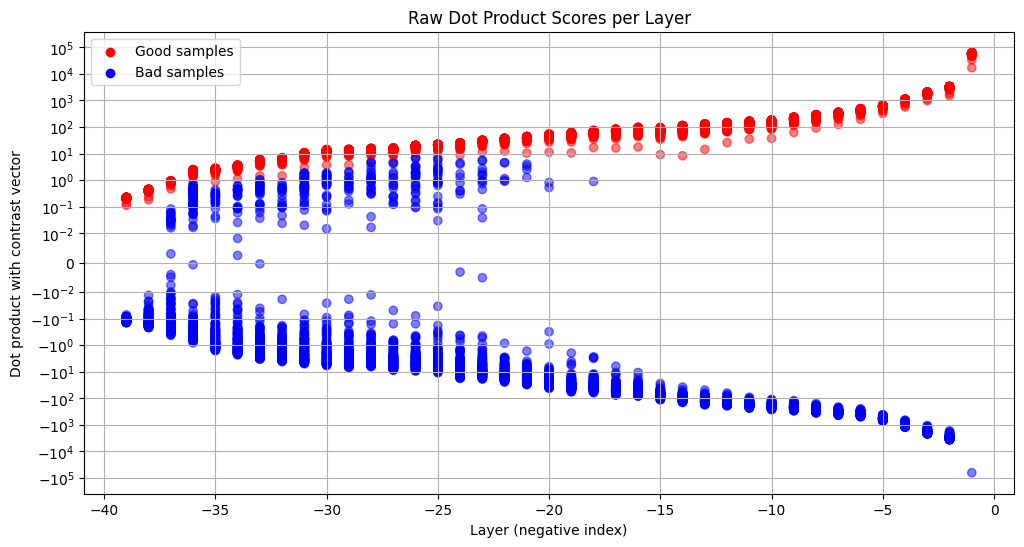

In [8]:
plt.figure(figsize=(12, 6))
plt.scatter([], [], c='red', label='Good samples')
plt.scatter([], [], c='blue', label='Bad samples')
plt.scatter(all_layers, all_scores, c=all_colors, alpha=0.5)
plt.yscale('symlog', linthresh=1e-2)
plt.title("Raw Dot Product Scores per Layer")
plt.xlabel("Layer (negative index)")
plt.ylabel("Dot product with contrast vector")
plt.grid(True)
plt.legend()
plt.savefig("scatter_contrast_projection.png", dpi=300)
plt.show()